In [10]:
import rebound
%matplotlib inline
import matplotlib.pyplot as plt
import observations
import state
import numpy as np

In [2]:
true_state = state.State(planets=[{"m":1e-3, "a":1., "h":0.2}])
obs = observations.FakeObservation(true_state, Npoints=100, error=1e-4, tmax=10.)

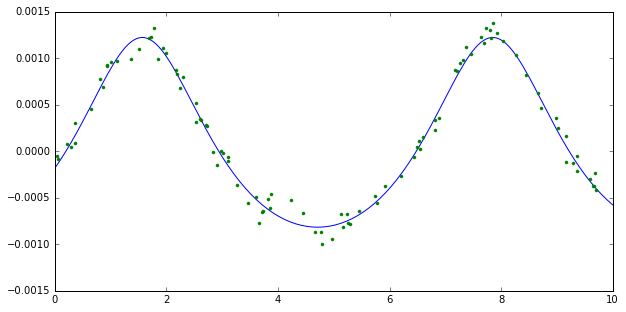

In [3]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
times, rv = true_state.get_rv_plotting(tmax=10.)
ax.plot(times, rv)
ax.plot(obs.t, obs.rv, ".")

In [4]:
true_state.get_chi2(obs)

0.8236261209363378

In [5]:
varState = state.StateVar(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0.}], ignore_vars=["a","m"])

varState.get_chi2(obs)

0.8236261209363378

In [6]:
print(varState.planets_vars)

[['h', 'k']]


(0.82362612093634158,
 array([-0.47582265, -1.38635811]),
 array([[ 127.19253159,   -6.64105744],
        [  -6.64105744,  123.08841551]]))

In [19]:
Delta = 1e-4
s = state.StateVar(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0.}], ignore_vars=["a","m"])
chi2 = s.get_chi2(obs)
fd_d = np.zeros(s.Nvars)
fd_dd = np.zeros((s.Nvars,s.Nvars))
for i in range(s.Nvars):
    shift = np.zeros(s.Nvars)
    shift[i] = Delta
    s.shift(shift);
    chi2p = s.get_chi2(obs)
    s.shift(-shift);
    fd_d[i] = (chi2p-chi2)/Delta
    for j in range(s.Nvars):
        shift = np.zeros(s.Nvars)
        shift[i] += Delta
        shift[j] += Delta
        s.shift(shift);
        chi2pp = s.get_chi2(obs)
        s.shift(-shift);
        
        shift = np.zeros(s.Nvars)
        shift[i] -= Delta
        shift[j] += Delta
        s.shift(shift);
        chi2mp = s.get_chi2(obs)
        s.shift(-shift);
        
        shift = np.zeros(s.Nvars)
        shift[i] += Delta
        shift[j] -= Delta
        s.shift(shift);
        chi2pm = s.get_chi2(obs)
        s.shift(-shift);
        
        shift = np.zeros(s.Nvars)
        shift[i] -= Delta
        shift[j] -= Delta
        s.shift(shift);
        chi2mm = s.get_chi2(obs)
        s.shift(-shift);
        
        fd_dd[i][j] = (chi2pp-chi2mp-chi2pm+chi2mm)/(4.*Delta**2)

chi2, v_d, v_dd = s.get_chi2_d_dd(obs)

print(fd_d)
print(v_d)
print(fd_dd)
print(v_dd)



[-0.46946273 -1.38020369]
[-0.47582265 -1.38635811]
[[ 127.19253067   -6.64105646]
 [  -6.64105646  123.08841714]]
[[ 127.19253159   -6.64105744]
 [  -6.64105744  123.08841551]]
